CV5330 Lab 4 Yifan Li.

Face mask detection with PyTorch Faster-RCNN model.

# Setup
Set up the environment and install required libaries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install fiftyone
!pip install torch torchvision

     |████████████████████████████████| 1.3 MB 4.2 MB/s 
     |████████████████████████████████| 508 kB 45.1 MB/s 
     |████████████████████████████████| 645 kB 42.9 MB/s 
     |████████████████████████████████| 29.2 MB 1.8 MB/s 
     |████████████████████████████████| 132 kB 44.0 MB/s 
     |████████████████████████████████| 226 kB 51.6 MB/s 
     |████████████████████████████████| 47.8 MB 3.1 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 106 kB 48.1 MB/s 
     |████████████████████████████████| 79.9 MB 127 kB/s 
     |████████████████████████████████| 132 kB 53.1 MB/s 
     |████████████████████████████████| 564 kB 28.8 MB/s 
     |████████████████████████████████| 13.2 MB 20.5 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 68 kB 6.5 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 79 kB 8.6 MB/s 
     |██████████████████

In [3]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../


Cloning into 'vision'...
remote: Enumerating objects: 113441, done.
remote: Counting objects: 100% (6125/6125), done.
remote: Compressing objects: 100% (1053/1053), done.
remote: Total 113441 (delta 5605), reused 5407 (delta 5041), pack-reused 107316
Receiving objects: 100% (113441/113441), 220.02 MiB | 14.07 MiB/s, done.
Resolving deltas: 100% (98276/98276), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version


In [4]:
!pip install opencv-python-headless==4.5.4.60 fiftyone

     |████████████████████████████████| 47.6 MB 2.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


# Loading custom data from MakeML Mask dataset

ref: https://makeml.app/datasets/mask

Dataset will be mounted by FiftyOne dataset for visualization and analyzation.

ref: https://voxel51.com/

The original dataset is divided into three subset:
- training set, containing img id 0 - 597, 598 imgs
- validate set, containing img id 598 - 725, 128 imgs
- testing set, containing img id 726 - 852, 127 imgs

https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html

In [5]:
import torch

torch.manual_seed(1)

## Convert dataset format
The original data type from MakeML is in VOC format. For better analyzation using FiftyOne Dataset and run the traing correctly, the dataset format needs to be converted into COCO format following the instructio in this github repository.

ref: https://github.com/yukkyo/voc2coco

If rerunning this notebook on your own device, modify the path of the dataset to get corrent data.

In [7]:
import fiftyone as fo

# The directory containing the dataset to import
dataset_dir_train_data = "/content/drive/My Drive/Northeastern/Spring2022/CS5330/lab4/res/images/train"
dataset_dir_validate_data = "/content/drive/My Drive/Northeastern/Spring2022/CS5330/lab4/res/images/validate"
dataset_dir_test_data = "/content/drive/My Drive/Northeastern/Spring2022/CS5330/lab4/res/images/test"

# The type of the dataset being imported
dataset_type = fo.types.COCODetectionDataset  # in COCO

dataset_train = fo.Dataset.from_dir(
    dataset_type=dataset_type,
    dataset_dir=dataset_dir_train_data,
    name="dataset_train"
)

dataset_validate = fo.Dataset.from_dir(
    dataset_type=dataset_type,
    dataset_dir=dataset_dir_validate_data,
    name="dataset_validate"
)

dataset_test = fo.Dataset.from_dir(
    dataset_type=dataset_type,
    dataset_dir=dataset_dir_test_data,
    name="dataset_test"
)

Migrating database to v0.15.0.1
 100% |█████████████████| 598/598 [3.5s elapsed, 0s remaining, 179.9 samples/s]      
 100% |█████████████████| 128/128 [828.9ms elapsed, 0s remaining, 156.3 samples/s]      
 100% |█████████████████| 127/127 [629.7ms elapsed, 0s remaining, 201.7 samples/s]      


## Clean up datasets if needed
If any undesired dataset was generated, use the dataset_name.delete() method to remove it. 


In [8]:
# If you failed to generate the dataset, uncomment this section to remove the datasets and retry

# import fiftyone as fo

# dataset_train.delete()
# dataset_validate.delete()
# dataset_test.delete()

# Verify datasets are removed
# print(fo.list_datasets())

## Compute metadata on our dataset.

In [9]:
dataset_train.compute_metadata()
dataset_validate.compute_metadata()
dataset_train.compute_metadata()

## visualize this dataset by FiftyOne API

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


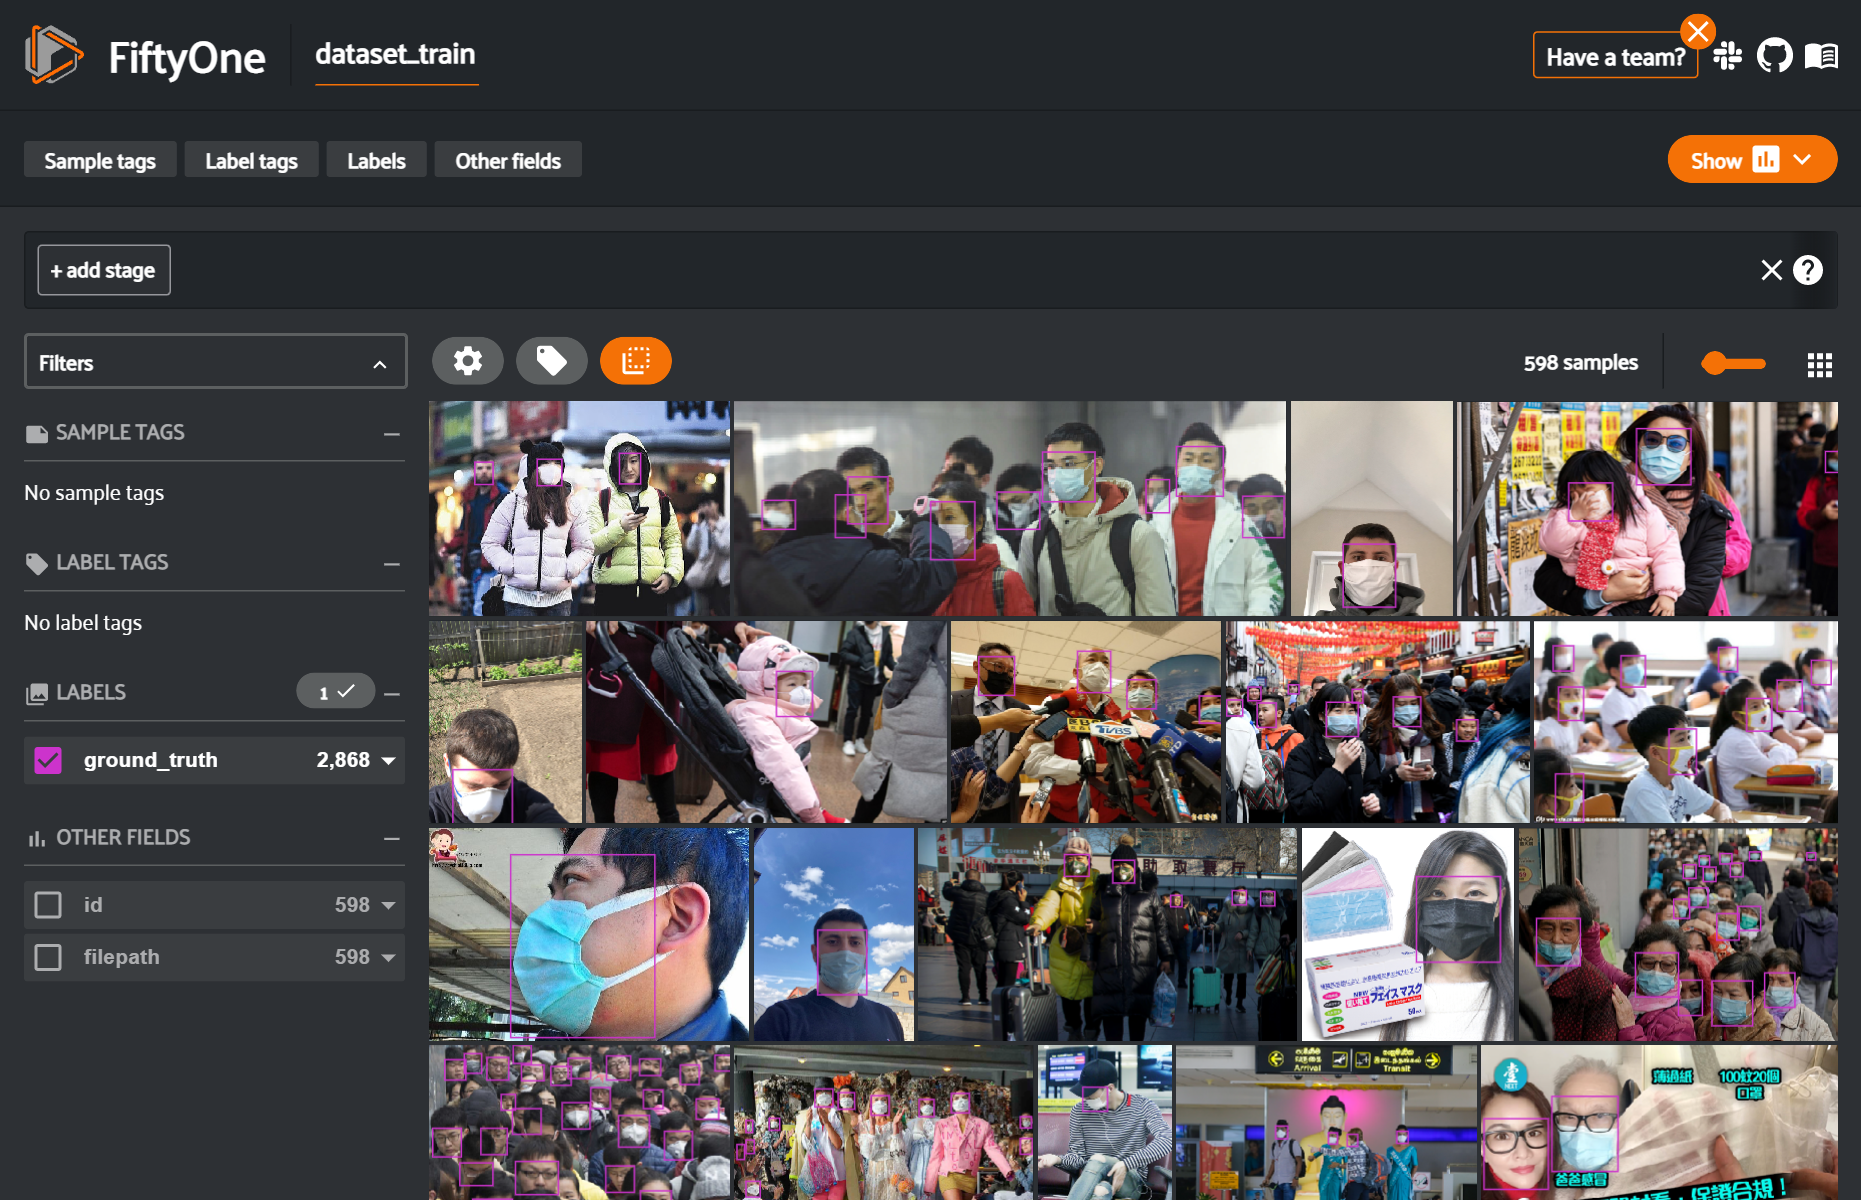

<IPython.core.display.Javascript object>

In [10]:
session = fo.launch_app(dataset_train)

# PyTorch dataset and training setup

## Connect PyTorch dataset from the FiftyOne datasite

In [11]:
import torch
import fiftyone.utils.coco as fouc
from PIL import Image


class FiftyOneTorchDataset(torch.utils.data.Dataset):
    """A class to construct a PyTorch dataset from a FiftyOne dataset.
    
    Args:
        fiftyone_dataset: a FiftyOne dataset or view that will be used for training or testing
        transforms (None): a list of PyTorch transforms to apply to images and targets when loading
        gt_field ("ground_truth"): the name of the field in fiftyone_dataset that contains the 
            desired labels to load
        classes (None): a list of class strings that are used to define the mapping between
            class names and indices. If None, it will use all classes present in the given fiftyone_dataset.
    """

    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        area = []
        iscrowd = []
        detections = sample[self.gt_field].detections
        for det in detections:
            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_label(
                det, metadata, category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(coco_obj.category_id)
            area.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.as_tensor([idx])
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

## Define Faster-RCNN with a ResNet50 backbone
Faster-RCNN with a ResNet50 backbone from Torchvision and modifies the classifier for the number of classes

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

## create traing loops
A simple training loop which is going to take a model and our PyTorch datasets as input and use the train_one_epoch() and evaluate() functions from the Torchvision object detection code

In [13]:
# Import functions from the torchvision references we cloned
from engine import train_one_epoch, evaluate
import utils

def do_training(model, torch_dataset, torch_dataset_test, num_epochs=4):
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)
    
    data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

## Set data augmentation for a random horizonal flip

In [14]:
# From the torchvision references we cloned
import transforms as T

train_transforms = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(0.5)])
test_transforms = T.Compose([T.ToTensor()])

## Set label map

In [15]:
mask_list = ["with_mask", "without_mask", "mask_weared_incorrect"]

## Build PyTorch dataset

In [16]:
# use our dataset and defined transformations
torch_dataset = FiftyOneTorchDataset(dataset_train, train_transforms,
        classes=mask_list)
torch_dataset_test = FiftyOneTorchDataset(dataset_validate, test_transforms, 
        classes=mask_list)


# Training and Evaluation

## Do trainning

In [17]:
model = get_model(len(mask_list)+1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [18]:
do_training(model, torch_dataset, torch_dataset_test, num_epochs=4)


Using device cuda


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/299]  eta: 0:11:09  lr: 0.000022  loss: 1.7390 (1.7390)  loss_classifier: 1.3511 (1.3511)  loss_box_reg: 0.1908 (0.1908)  loss_objectness: 0.1689 (0.1689)  loss_rpn_box_reg: 0.0282 (0.0282)  time: 2.2390  data: 0.3027  max mem: 2334
Epoch: [0]  [ 10/299]  eta: 0:09:47  lr: 0.000189  loss: 1.5840 (1.6774)  loss_classifier: 1.3152 (1.2208)  loss_box_reg: 0.1294 (0.1479)  loss_objectness: 0.1415 (0.2779)  loss_rpn_box_reg: 0.0142 (0.0309)  time: 2.0313  data: 0.0364  max mem: 4020
Epoch: [0]  [ 20/299]  eta: 0:09:07  lr: 0.000357  loss: 1.0312 (1.2698)  loss_classifier: 0.7716 (0.8607)  loss_box_reg: 0.1941 (0.1987)  loss_objectness: 0.0936 (0.1827)  loss_rpn_box_reg: 0.0134 (0.0277)  time: 1.9467  data: 0.0100  max mem: 4020
Epoch: [0]  [ 30/299]  eta: 0:08:47  lr: 0.000525  loss: 0.8191 (1.1747)  loss_classifier: 0.4432 (0.7386)  loss_box_reg: 0.2945 (0.2625)  loss_objectness: 0.0514 (0.1438)  loss_rpn_box_reg: 0.0186 (0.0299)  time: 1.9208  data: 0.0112  max mem: 4020


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/128]  eta: 0:01:17  model_time: 0.4344 (0.4344)  evaluator_time: 0.0078 (0.0078)  time: 0.6081  data: 0.1644  max mem: 4206
Test:  [100/128]  eta: 0:00:11  model_time: 0.3794 (0.3765)  evaluator_time: 0.0021 (0.0087)  time: 0.3894  data: 0.0050  max mem: 4206
Test:  [127/128]  eta: 0:00:00  model_time: 0.3754 (0.3765)  evaluator_time: 0.0026 (0.0081)  time: 0.3864  data: 0.0050  max mem: 4206
Test: Total time: 0:00:50 (0.3932 s / it)
Averaged stats: model_time: 0.3754 (0.3765)  evaluator_time: 0.0026 (0.0081)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.344
 Aver

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [1]  [  0/299]  eta: 0:14:12  lr: 0.005000  loss: 0.3177 (0.3177)  loss_classifier: 0.0775 (0.0775)  loss_box_reg: 0.2329 (0.2329)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0068 (0.0068)  time: 2.8506  data: 0.2375  max mem: 4206
Epoch: [1]  [ 10/299]  eta: 0:09:25  lr: 0.005000  loss: 0.3957 (0.3980)  loss_classifier: 0.1308 (0.1374)  loss_box_reg: 0.2633 (0.2453)  loss_objectness: 0.0034 (0.0071)  loss_rpn_box_reg: 0.0068 (0.0082)  time: 1.9552  data: 0.0306  max mem: 4206
Epoch: [1]  [ 20/299]  eta: 0:08:55  lr: 0.005000  loss: 0.4190 (0.4118)  loss_classifier: 0.1308 (0.1437)  loss_box_reg: 0.2623 (0.2492)  loss_objectness: 0.0034 (0.0076)  loss_rpn_box_reg: 0.0067 (0.0113)  time: 1.8716  data: 0.0098  max mem: 4206
Epoch: [1]  [ 30/299]  eta: 0:08:32  lr: 0.005000  loss: 0.3891 (0.3762)  loss_classifier: 0.1003 (0.1263)  loss_box_reg: 0.2165 (0.2293)  loss_objectness: 0.0026 (0.0064)  loss_rpn_box_reg: 0.0054 (0.0142)  time: 1.8802  data: 0.0100  max mem: 4206


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/128]  eta: 0:01:20  model_time: 0.4424 (0.4424)  evaluator_time: 0.0027 (0.0027)  time: 0.6304  data: 0.1836  max mem: 4206
Test:  [100/128]  eta: 0:00:10  model_time: 0.3733 (0.3745)  evaluator_time: 0.0028 (0.0062)  time: 0.3862  data: 0.0051  max mem: 4206
Test:  [127/128]  eta: 0:00:00  model_time: 0.3757 (0.3746)  evaluator_time: 0.0027 (0.0058)  time: 0.3836  data: 0.0052  max mem: 4206
Test: Total time: 0:00:49 (0.3886 s / it)
Averaged stats: model_time: 0.3757 (0.3746)  evaluator_time: 0.0027 (0.0058)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.609
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.462
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.464
 Aver

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [2]  [  0/299]  eta: 0:13:25  lr: 0.005000  loss: 0.3662 (0.3662)  loss_classifier: 0.2247 (0.2247)  loss_box_reg: 0.1391 (0.1391)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 2.6939  data: 0.2108  max mem: 4206
Epoch: [2]  [ 10/299]  eta: 0:09:57  lr: 0.005000  loss: 0.2247 (0.2659)  loss_classifier: 0.0600 (0.1007)  loss_box_reg: 0.1391 (0.1606)  loss_objectness: 0.0007 (0.0013)  loss_rpn_box_reg: 0.0020 (0.0034)  time: 2.0677  data: 0.0292  max mem: 4206
Epoch: [2]  [ 20/299]  eta: 0:09:08  lr: 0.005000  loss: 0.1728 (0.2386)  loss_classifier: 0.0522 (0.0862)  loss_box_reg: 0.1118 (0.1477)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0020 (0.0032)  time: 1.9280  data: 0.0110  max mem: 4206
Epoch: [2]  [ 30/299]  eta: 0:08:29  lr: 0.005000  loss: 0.2098 (0.2547)  loss_classifier: 0.0770 (0.0878)  loss_box_reg: 0.1135 (0.1596)  loss_objectness: 0.0010 (0.0027)  loss_rpn_box_reg: 0.0035 (0.0046)  time: 1.7993  data: 0.0104  max mem: 4206


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/128]  eta: 0:01:14  model_time: 0.4259 (0.4259)  evaluator_time: 0.0022 (0.0022)  time: 0.5822  data: 0.1527  max mem: 4391
Test:  [100/128]  eta: 0:00:10  model_time: 0.3750 (0.3751)  evaluator_time: 0.0021 (0.0050)  time: 0.3868  data: 0.0054  max mem: 4391
Test:  [127/128]  eta: 0:00:00  model_time: 0.3680 (0.3750)  evaluator_time: 0.0022 (0.0048)  time: 0.3816  data: 0.0052  max mem: 4391
Test: Total time: 0:00:49 (0.3879 s / it)
Averaged stats: model_time: 0.3680 (0.3750)  evaluator_time: 0.0022 (0.0048)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.507
 Aver

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [3]  [  0/299]  eta: 0:12:57  lr: 0.000500  loss: 0.1250 (0.1250)  loss_classifier: 0.0339 (0.0339)  loss_box_reg: 0.0892 (0.0892)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 2.6020  data: 0.2062  max mem: 4391
Epoch: [3]  [ 10/299]  eta: 0:09:39  lr: 0.000500  loss: 0.2021 (0.2193)  loss_classifier: 0.0453 (0.0637)  loss_box_reg: 0.1561 (0.1485)  loss_objectness: 0.0007 (0.0021)  loss_rpn_box_reg: 0.0021 (0.0050)  time: 2.0051  data: 0.0272  max mem: 4391
Epoch: [3]  [ 20/299]  eta: 0:08:46  lr: 0.000500  loss: 0.2008 (0.2288)  loss_classifier: 0.0453 (0.0747)  loss_box_reg: 0.1483 (0.1470)  loss_objectness: 0.0007 (0.0021)  loss_rpn_box_reg: 0.0021 (0.0050)  time: 1.8498  data: 0.0095  max mem: 4391
Epoch: [3]  [ 30/299]  eta: 0:08:27  lr: 0.000500  loss: 0.1963 (0.2237)  loss_classifier: 0.0486 (0.0735)  loss_box_reg: 0.1298 (0.1415)  loss_objectness: 0.0004 (0.0031)  loss_rpn_box_reg: 0.0022 (0.0056)  time: 1.8197  data: 0.0094  max mem: 4391


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:165: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/128]  eta: 0:01:17  model_time: 0.4292 (0.4292)  evaluator_time: 0.0020 (0.0020)  time: 0.6028  data: 0.1654  max mem: 4391
Test:  [100/128]  eta: 0:00:10  model_time: 0.3751 (0.3745)  evaluator_time: 0.0018 (0.0051)  time: 0.3836  data: 0.0054  max mem: 4391
Test:  [127/128]  eta: 0:00:00  model_time: 0.3753 (0.3745)  evaluator_time: 0.0018 (0.0048)  time: 0.3821  data: 0.0050  max mem: 4391
Test: Total time: 0:00:49 (0.3878 s / it)
Averaged stats: model_time: 0.3753 (0.3745)  evaluator_time: 0.0018 (0.0048)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.599
 Aver

## Run testing with our test dataset

In [19]:
import fiftyone as fo

def convert_torch_predictions(preds, det_id, s_id, w, h, classes):
    # Convert the outputs of the torch model into a FiftyOne Detections object
    dets = []
    for bbox, label, score in zip(
        preds["boxes"].cpu().detach().numpy(), 
        preds["labels"].cpu().detach().numpy(), 
        preds["scores"].cpu().detach().numpy()
    ):
        # Parse prediction into FiftyOne Detection object
        x0,y0,x1,y1 = bbox
        coco_obj = fouc.COCOObject(det_id, s_id, int(label), [x0, y0, x1-x0, y1-y0])
        det = coco_obj.to_detection((w,h), classes)
        det["confidence"] = float(score)
        dets.append(det)
        det_id += 1
        
    detections = fo.Detections(detections=dets)
        
    return detections, det_id

def add_detections(model, torch_dataset, view, field_name="predictions"):
    # Run inference on a dataset and add results to FiftyOne
    torch.set_num_threads(1)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    model.eval()
    model.to(device)
    image_paths = torch_dataset.img_paths
    classes = torch_dataset.classes
    det_id = 0
    
    with fo.ProgressBar() as pb:
        for img, targets in pb(torch_dataset):
            # Get FiftyOne sample indexed by unique image filepath
            img_id = int(targets["image_id"][0])
            img_path = image_paths[img_id]
            sample = view[img_path]
            s_id = sample.id
            w = sample.metadata["width"]
            h = sample.metadata["height"]
            
            # Inference
            preds = model(img.unsqueeze(0).to(device))[0]
            
            detections, det_id = convert_torch_predictions(
                preds, 
                det_id, 
                s_id, 
                w, 
                h, 
                classes,
            )
            
            sample[field_name] = detections
            sample.save()

In [20]:
torch_dataset_test = FiftyOneTorchDataset(dataset_test, test_transforms, 
        classes=mask_list)

In [21]:
add_detections(model, torch_dataset_test, dataset_test, field_name="predictions")

Using device cuda
 100% |█████████████████| 127/127 [1.9m elapsed, 0s remaining, 1.2 samples/s]      


## Evaluate the result with test dataset and IoU threshold of 0.5

In [ ]:
results = fo.evaluate_detections(
    dataset_test, 
    "predictions", 
    classes=mask_list, 
    eval_key="eval", 
    compute_mAP=True,
    iou=0.5
)

## Calculate the mAP

In [33]:
results.mAP()

0.44061254282194257

In [34]:
results.print_report()

                       precision    recall  f1-score   support

            with_mask       0.65      0.97      0.78       411
         without_mask       0.33      0.91      0.48        79
mask_weared_incorrect       0.19      0.89      0.31        18

            micro avg       0.53      0.96      0.68       508
            macro avg       0.39      0.92      0.52       508
         weighted avg       0.58      0.96      0.72       508



## Find the pr curve

In [35]:
results.plot_pr_curves()

##  Visualize the result by FiftyOne API

In [32]:
session.view = dataset_test.sort_by("eval_fp", reverse=True)